In [279]:
import pytesseract
from PIL import Image, ImageFilter, ImageEnhance



#Define path to tessaract.exe
path_to_tesseract = r'C:\Program Files\Tesseract-OCR\tesseract.exe'

#Define path to image
path_to_image = '00d11cfb-7b1d-4854-8eef-8190a498124d.jpg'

#Point tessaract_cmd to tessaract.exe
pytesseract.tesseract_cmd = path_to_tesseract

#Open image with PIL
img = Image.open(path_to_image)

#Extract text from image
text = pytesseract.image_to_string(img)


In [280]:
text

''

In [281]:
from scipy import ndimage

#rotation angle in degree
img = ndimage.rotate(img, 4.5)
img = Image.fromarray(img)
save_path = 'rotated_image.jpg'
img.save(save_path)

In [282]:
preprocessed_image = img.filter(ImageFilter.GaussianBlur(radius=0))

preprocessed_image = preprocessed_image.convert("L")  # Convert to grayscale
preprocessed_image = ImageEnhance.Contrast(preprocessed_image).enhance(1.5)  # Increase contrast
preprocessed_image = preprocessed_image.filter(ImageFilter.UnsharpMask(radius=1.5, percent=150, threshold=30))


# Perform OCR using Tesseract
text = pytesseract.image_to_string(preprocessed_image)

# Print the extracted text
print(text)

UMOWA SPRZEDAZY SAMOCHODU

2021-06-20

Zawarta w dniu . pomigdzy:

ar dokumentu tozsamosei:
Presydenta miata Wacyn
wydany preez etn ”

a

-, ‘: FANIYA HUMILIN
Kupujacym (imig 1 nazwisko):..

13065125: 1186231
PESEL?: BM saeeue NIP: , 3681862210,

Adres:

Rodzaj i nr dokumentu tozsamo’

yd
wydany prez Peer

Preedmiotem umowy jest sprzedaz pojazdi

Mazda
marka‘model .Ma#4

6131968

rok produkeji
ar nadworia

nr rejestracyjr ae preebieg (km).

Sprzedajacy oswiadera, 2e pojazd bedgcy przedmiotem umowy stanowi jego wylyczng wlasnosé, jest
wolny od wad prawnych oraz praw osdb trzecich, Ze nie toczy sig Zadne postgpowanie, ktorego

przedmiotem jest ten pojazd, Ze nie stanowi on rownie? przedmiotu zabezpicczenia.

S aA 195843
Strony ustalily wartosé przedmiotu umowy na kwotg: .

(slowni ierdzenia. Kazda konstrukeja i kazdet
Sprzedajacy przenosi na rzecz kupujacego wlasnosé przedmiotu, o ktérym mowa w §1 niniejszej umowy
za kwotg okreslong w §3 niniejsze) umowy. ktére} otrzymanie sprzedajacy kw

In [262]:
text = pytesseract.image_to_string(preprocessed_image)

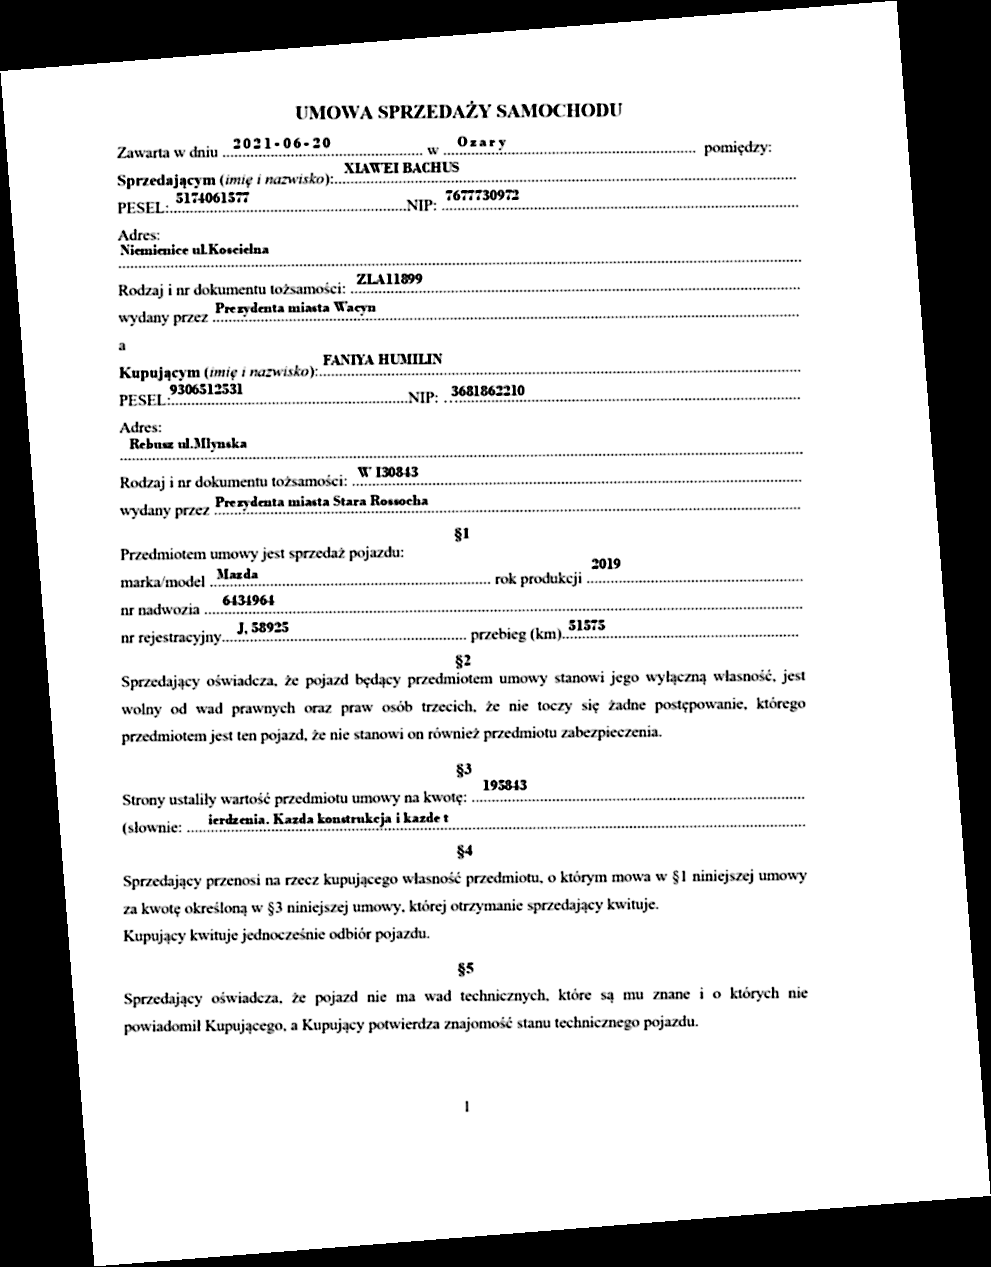

In [263]:
preprocessed_image

In [ ]:
# 00d11cfb-7b1d-4854-8eef-8190a498124d.jpg

In [296]:
import cv2
import numpy as np
# load path of the image
original_image=cv2.imread("00d11cfb-7b1d-4854-8eef-8190a498124d.jpg")
cv2.imshow('original image',original_image)
cv2.waitKey(0)
# create a sharpening kernel
sharpen_filter=np.array([[-1,-1,-1],
                 [-1,9,-1],
                [-1,-1,-1]])
# applying kernels to the input image to get the sharpened image
sharp_image=cv2.filter2D(original_image,-1,sharpen_filter)
cv2.imshow('Required image',sharp_image)
cv2.waitKey(0)
cv2.destroyAllWindows()